<div class="alert alert-block alert-info">
    
# Model 2: Train an embedding (Word2Vec)

https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

https://github.com/javaidnabi31/Word-Embeddding-Sentiment-Classification

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/?fbclid=IwAR1khMPlmKZhB9sW3y9kqmm3cYex6Rl5yDIyD8JGH677MJ5IP6wdmYoniZI

In [1]:
"""Module for loading the train and test data.

This module supports loading the data in two seperate ways.
The first, which is done by calling the load_train and load_test functions,
opens and parses the text files one by one. Because of the abundance of files,
this can take a while.
The second way of loading the data is by opening a pickle file containing the
results of the load_train and load_test functions. To create this pickle file,
call the create_data_pickle function once. Afterwards, you will be ablo to
quickly load the data using the load_data_pickle function.
"""
import collections
import glob
import os
import re
import warnings

#import utils


## Default data folder names ## 


DEFAULT_DATA_LOCATION = 'Data'
DEFAULT_TRAIN_DATA_LOCATION = os.path.join(DEFAULT_DATA_LOCATION, 'Train')
DEFAULT_TEST_DATA_LOCATION = os.path.join(DEFAULT_DATA_LOCATION, 'Test')

DEFAULT_PICKLE_PATH = os.path.join(DEFAULT_DATA_LOCATION, 'data.pkl')

PRICE_LOCATION_FILE_NAME = 'hotels.txt'
HOTEL_REVIEWS_FILE_TEMPLATE = 'Hotel_*.txt'
TEST_REVIEWS_FILE_TEMPLATE = '*.txt'


## Classes to store the parsed data in. ##


Hotel = collections.namedtuple(
  'Hotel', ['id', 'price', 'location'])
Review = collections.namedtuple(
  'Review', [
      'id', 'author', 'content', 'date', 'rating', 'subratings', 'hotel'])
Subratings = collections.namedtuple(
  'Subratings', [
      'value', 'rooms', 'location', 'cleanliness',
      'front_desk', 'service', 'business_service'])


## Helper functions for parsing data ##


def _parse_price_location_file(price_location_lines):
  hotels = {}
  for hotel_line in price_location_lines[1:]:
    tokens = hotel_line.strip().split(',')
    hotel_id = int(tokens[0])
    price = int(tokens[1])
    location = tokens[2]
    hotels[hotel_id] = Hotel(id=hotel_id, price=price, location=location)
  return hotels


def _extract_id_from_file_name(review_file_name):
  regex_res = re.findall('\d+', review_file_name)
  assert len(regex_res) == 1
  return int(regex_res[0])


_AUTHOR_TAG = '<Author>'
_CONTENT_TAG = '<Content>'
_DATE_TAG = '<Date>'
_RATING_TAG = '<Overall_rating>'
_SUBRATING_TAG = '<Subratings>'
_PRICE_TAG = '<Price>'
_LOCATION_TAG = '<Location>'


def _parse_string_line(line, tag):
  assert line.startswith(tag)
  return line.strip()[len(tag):]


def _parse_author_line(author_line):
  return _parse_string_line(author_line, _AUTHOR_TAG)


def _parse_content_line(content_line):
  return _parse_string_line(content_line, _CONTENT_TAG)


def _parse_date_line(date_line):
  return _parse_string_line(date_line, _DATE_TAG)


def _parse_rating_line(rating_line):
  rating_string = _parse_string_line(rating_line, _RATING_TAG)
  return int(rating_string)


def _parse_price_line(price_line):
  price_string = _parse_string_line(price_line, _PRICE_TAG)
  return int(price_string)


def _parse_location_line(location_line):
  return _parse_string_line(location_line, _LOCATION_TAG)


def _parse_subratings_line(subratings_line):
  subratings_string = _parse_string_line(subratings_line, _SUBRATING_TAG)
  subrating_tokens = subratings_string.split(',')

  subratings = {}
  for token in subrating_tokens:
    left, right = token.strip().split('=')
    subratings[left] = int(right)

  return Subratings(**subratings)


def _parse_single_hotel_review(review_lines, hotel):
  author_line, content_line, date_line, overall_rating_line, subratings_line = (
      review_lines)
  # Parse each of the lines
  author = _parse_author_line(author_line)
  content = _parse_content_line(content_line)
  date = _parse_date_line(date_line)
  rating = _parse_rating_line(overall_rating_line)
  subratings = _parse_subratings_line(subratings_line)
  return Review(
      id=-1, author=author, content=content, date=date, rating=rating,
      subratings=subratings, hotel=hotel)


def _parse_hotel_review_file(hotel_review_lines, hotel):
  assert len(hotel_review_lines)%6 == 0
  hotel_reviews = []
  for start_idx in range(0, len(hotel_review_lines), 6):
    review_lines = hotel_review_lines[start_idx:start_idx+5]
    hotel_reviews.append(_parse_single_hotel_review(review_lines, hotel))
  return hotel_reviews


def _parse_test_review_file(test_review_lines, review_id):
  assert len(test_review_lines) == 5
  author_line, content_line, date_line, price_line, location_line = (
      test_review_lines)
  author = _parse_author_line(author_line)
  content = _parse_content_line(content_line)
  date = _parse_date_line(date_line)
  price = _parse_price_line(price_line)
  location = _parse_location_line(location_line)
  unknown_hotel = Hotel(id=-1, price=price, location=location)
  review = Review(
      id=review_id, author=author, content=content, date=date, rating=-1,
      subratings=None, hotel=unknown_hotel)
  return review


## Functions for loading and parsing all of the data ##


def load_train(train_data_folder=DEFAULT_TRAIN_DATA_LOCATION):
  """Loads and parses the train data.

  Args:
    train_data_folder: string containing the path to the folder containing the
        training data.

  Returns:
    A list of all the reviews. Each review is a namedtuple object containing
    the author, content, date, rating, subratings and hotel data. The hotel
    data is a namedtuple containing the price and location of the hotel.
    The subratings is a namedtuple containing the value, rooms, location,
    cleanliness, front_desk, service and business_service ratings. Different
    reviews of the same hotel will point to the same Hotel object.
  """
  price_location_file_path = os.path.join(
      train_data_folder, PRICE_LOCATION_FILE_NAME)
  review_file_paths = glob.glob(os.path.join(
      train_data_folder, HOTEL_REVIEWS_FILE_TEMPLATE))
  
  # First, load and parse the hotel price locations file
  with open(price_location_file_path, 'r') as price_location_file:
    price_location_lines = price_location_file.readlines()
  hotels_dict = _parse_price_location_file(price_location_lines)
  assert len(hotels_dict) == len(review_file_paths)
  
  # Second, load and parse each of the hotel review files
  reviews = []
  for review_file_path in review_file_paths:
    with open(review_file_path, 'r') as review_file:
      review_file_lines = review_file.readlines()
    hotel_id = _extract_id_from_file_name(os.path.basename(review_file_path))
    hotel = hotels_dict[hotel_id]
    hotel_reviews = _parse_hotel_review_file(review_file_lines, hotel)
    reviews += hotel_reviews
  return reviews


def load_test(test_data_folder=DEFAULT_TEST_DATA_LOCATION):
  """Loads and parses the test data.

  Args:
    test_data_folder: string containing the path to the folder containing the]
        test data.

  Returns:
    A list of all the test reviews, sorted by the review id. Each review is a
    namedtuple object containing the author, content, date and hotel data. The
    hotel data is a namedtuple containing the price and location of the hotel.
    Since the hotel id is unknown, different reviews of the same hotel will 
    point to different Hotel objects.
  """
  review_file_paths = glob.glob(os.path.join(
      test_data_folder, TEST_REVIEWS_FILE_TEMPLATE))
  # Parse all the review files one by one
  reviews = []
  for review_file_path in review_file_paths:
    review_id = _extract_id_from_file_name(os.path.basename(review_file_path))
    with open(review_file_path, 'r') as review_file:
      review_file_lines = review_file.readlines()
    reviews.append(_parse_test_review_file(review_file_lines, review_id))
  # Sort them by review id
  key_getter = lambda r: r.id
  reviews.sort(key=key_getter)
  #assert range(1, len(reviews)+1) == map(key_getter, reviews)
  return reviews


## Functions for loading the data from a pickle file. ##


def create_pickled_data(train_data_folder=DEFAULT_TRAIN_DATA_LOCATION,
                        test_data_folder=DEFAULT_TEST_DATA_LOCATION,
                        pickled_data_file_path=DEFAULT_PICKLE_PATH,
                        overwrite_old=True):
  """Creates the data pickle file.

  Loads and parses the train and test data, and then writes it to a single
  pickle file.

  Args: 
    train_data_folder: path to the train data folder.
    test_data_folder: path to the test data folder.
    pickled_data_file_path: location where the resulting pickle file should
        be stored.
  """
  if os.path.exists(pickled_data_file_path):
    if not overwrite_old:
      return 
    warnings.warn(
        "There already exists a data pickle file, which will be overwritten.")
  train_data = load_train(train_data_folder)
  test_data = load_test(test_data_folder)
  utils.dump_pickle(
      dict(train=train_data, test=test_data), pickled_data_file_path)


def load_pickled_data(pickled_data_file_path=DEFAULT_PICKLE_PATH):
  """Loads the train and test data from a pickle file.

  Args:
    pickled_data_file_path: location of the data pickle file.
  """
  return utils.load_pickle(pickled_data_file_path)



Number of reviews with a rating of 1: 12079
Number of reviews with a rating of 2: 15991
Number of reviews with a rating of 3: 20386
Number of reviews with a rating of 4: 61926
Number of reviews with a rating of 5: 84297


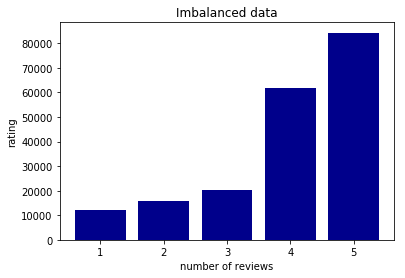

In [4]:
Train = load_train(DEFAULT_TRAIN_DATA_LOCATION)
i1=0
i2=0 
i3=0 
i4=0 
i5=0
for i in range(len(Train)):
    if Train[i][4] == 1:
        i1 += 1
    if Train[i][4] == 2:
        i2 += 1
    if Train[i][4] == 3:
        i3 += 1
    if Train[i][4] == 4:
        i4 += 1
    if Train[i][4] == 5:
        i5 += 1
print('Number of reviews with a rating of 1: '+str(i1))
print('Number of reviews with a rating of 2: '+str(i2))
print('Number of reviews with a rating of 3: '+str(i3))
print('Number of reviews with a rating of 4: '+str(i4))
print('Number of reviews with a rating of 5: '+str(i5))


import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5] 
  
# heights of bars 
height = [i1, i2, i3, i4, i5] 
  
# labels for bars 
tick_label = ['1', '2', '3', '4', '5'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['darkblue']) 
  
# naming the x-axis 
plt.xlabel('number of reviews') 
# naming the y-axis 
plt.ylabel('rating') 
# plot title 
plt.title('Imbalanced data') 
  
# function to show the plot 
plt.show() 

### Make contentlist , rating list and Hotel_id list

In [3]:
#Train = subtrain
#Put the content of each review into a list
import random
#Train = Train[0:30000]
random.shuffle(Train)

RealRating = list()
for i in range(len(Train)):
    if Train[i][4]!=-1:
        RealRating.append(Train[i])

Train = RealRating

content_list = list()


for i in range(len(list(Train))):
    content=(list(list(Train[i]))[2])
    content_list.append(content)

rating_list = list()

for i in range(len(list(Train))):
    rating =list(Train[i])[4]
    rating = rating - 1
    rating_list.append(rating)
    
Hotel_id_list = list()

for i in range(len(list(Train))):
    Hotel_id=(list(list(Train[i]))[6][0])
    Hotel_id_list.append(Hotel_id)

### Language detection: only English reviews

In [4]:
!pip install langdetect
from langdetect import detect
language = detect(content_list[0])
print(language)


notenglish = list()
nolanguage = list()
for i in range(len(content_list)):  #len(content_list)
    
    try:
    #language = detect(content_list[i])
        if( detect(content_list[i]) != 'en'):
            notenglish.append(i)
        
    except:
        nolanguage.append(i)
        
        
mergedlist = notenglish + nolanguage
print(mergedlist)

mergedlist.sort()
print(mergedlist)


times = 0
for i in range(len(mergedlist)): 
    content_list.pop(mergedlist[i] - times)
    rating_list.pop(mergedlist[i] - times)
    times = times + 1 

    

en
[3, 4, 14, 21, 25, 43, 45, 55, 59, 64, 76, 86, 87, 89, 96, 97, 102, 112, 115, 129, 136, 140, 143, 148, 163, 177, 178, 191, 206, 208, 213, 222, 233, 247, 249, 251, 254, 264, 269, 278, 280, 281, 289, 304, 307, 324, 336, 339, 341, 355, 360, 361, 363, 366, 367, 372, 378, 388, 390, 392, 398, 402, 408, 415, 418, 421, 426, 435, 440, 441, 442, 443, 462, 476, 478, 479, 481, 486, 487, 490, 499, 503, 506, 515, 530, 538, 548, 555, 559, 572, 575, 581, 585, 586, 592, 599, 609, 612, 621, 622, 623, 624, 633, 638, 639, 644, 650, 652, 654, 656, 665, 666, 673, 675, 676, 679, 687, 690, 697, 710, 713, 716, 725, 727, 732, 734, 741, 744, 745, 759, 761, 768, 769, 770, 783, 784, 788, 795, 803, 807, 811, 813, 818, 820, 821, 823, 825, 828, 829, 835, 854, 858, 867, 874, 878, 879, 893, 895, 904, 909, 936, 940, 945, 946, 947, 959, 965, 969, 972, 976, 986, 999, 1005, 1007, 1012, 1015, 1020, 1030, 1039, 1050, 1053, 1058, 1059, 1061, 1065, 1081, 1086, 1087, 1088, 1092, 1098, 1099, 1105, 1106, 1107, 1118, 1120, 1130

In [7]:
len(notenglish)

31560

In [8]:
len(nolanguage)

574

### Lemitization

In [9]:
!pip install nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer=WordNetLemmatizer()

for i in range(len(content_list)):
    listlemmatizer = list()
    input_str = word_tokenize(content_list[i]) # Puts every word of the string situated in content_list[i] seperately into a list
    for word in input_str:
        lem = lemmatizer.lemmatize(word)
        listlemmatizer.append(lem)
    content_list[i] = ' '.join(listlemmatizer) # Puts the seperate words back into one string where the words are seperated by one space ' '
    
print(content_list[1:10])

["Great Little Hotel Hotel Innova is a great hotel and doe n't pretend to be anything it is n't . I stayed there with a friend in May 2007 and although it 's not the luxurious surrroundings you might want for a stay in Paris , it is excellent value for a very good price.Room wa clean and spacious , staff were very helpful , towel changed and bed made everyday , tasty breakfast , Metro stop just across the road and a quiet location . I 'd definitely go there again on the same budget.We had a very busy and enjoyable few day and this hotel wa great to come back to after a hard day sightseeing . I can highly recommend the Cafe Pasteur across the road a well for a croque monsieur and a cold beer !", 'Wonderful low-key beach destination Colorful beachfront cabin', "Nice hotel , OK service , great breakfast We got a great price on this hotel from Priceline and it 's a really modern , clean hotel . The breakfast wa great and much bigger than a lot of place we 've stayed . The restaurant and br

### Define a vocabulary and only save those words in the content list

In [15]:
pip install -U nltk



The following command must be run outside of the IPython shell:

    $ pip install -U nltk

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [21]:
import nltk

nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

words = list()
for i in range(len(content_list)):
    input_str = word_tokenize(content_list[i])
    for word in input_str:
         words.append(word)
    
vocab = collections.Counter(words)

print(vocab.most_common(100))
print(vocab)

# keep tokens with a min occurrence
min_occurance = 100
word_bag = [k for k,c in vocab.items() if c >= min_occurance]
print(len(word_bag))

for i in range(len(content_list)): #len(content_list)
    tokens = word_tokenize(content_list[i])
    result = [w for w in tokens if w in word_bag]
    content_list[i] = ' '.join(result)
content_list[1:10]



[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[('the', 1657513), ('.', 1490179), (',', 1158657), ('and', 1039803), ('a', 947023), ('to', 772120), ('wa', 608337), ('in', 459227), ('of', 449787), ('I', 415486), ('is', 382151), ('for', 341387), ('The', 333513), ('hotel', 321865), ('we', 317094), ('room', 307523), ('it', 295114), ('!', 266444), ('at', 266098), ('you', 259473), ('were', 256037), ('with', 223312), ('on', 219580), ('that', 219224), ('but', 218793), ('not', 193501), ('very', 193119), ('We', 190457), ('had', 180156), ('are', 170289), (')', 167457), ('this', 165212), ('(', 161369), ('our', 156884), ('have', 153383), ('from', 146475), ('there', 130016), ("n't", 127436), ('they', 117313), ('be', 115577), ('all', 114575), ('great', 112705), ('would', 107570), ('so', 104751), ('stay', 104321), ('-', 101907), ('good', 99933), ('staff', 99926), ('my', 95217), ('night', 92419), ('did', 90088), ('one', 88636), ("'s", 83824), ('which', 82617), ('u', 82242), ('time', 81640), ('day', 80576), ('get', 76745), ('if', 76384), ('out', 7600

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



["Great Little Hotel Hotel is a great hotel and doe n't pretend to be anything it is n't . I stayed there with a friend in May 2007 and although it 's not the luxurious you might want for a stay in Paris , it is excellent value for a very good wa clean and spacious , staff were very helpful , towel changed and bed made everyday , tasty breakfast , Metro stop just across the road and a quiet location . I 'd definitely go there again on the same had a very busy and enjoyable few day and this hotel wa great to come back to after a hard day sightseeing . I can highly recommend the Cafe across the road a well for a and a cold beer !",
 'Wonderful beach destination beachfront cabin',
 "Nice hotel , OK service , great breakfast We got a great price on this hotel from Priceline and it 's a really modern , clean hotel . The breakfast wa great and much bigger than a lot of place we 've stayed . The restaurant and breakfast staff were very nice and helpful . The front desk staff left a lot to be 

### To dataframe

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


df = pd.DataFrame.from_dict(content_list)
df.columns = ['Review']
df.head(5)

df2 = pd.DataFrame.from_dict(rating_list)
df['Rating'] = df2

df['Hotel_id'] = pd.DataFrame.from_dict(Hotel_id_list, dtype = 'category')

df.head(20)



,Review,Rating,Hotel_id
0,Not what used to ... . even better We have sta...,4,81
1,Great Little Hotel Hotel is a great hotel and ...,3,424
2,Wonderful beach destination beachfront cabin,3,835
3,"Nice hotel , OK service , great breakfast We g...",2,236
4,Loved this Hotel ! ! ! We really enjoyed this ...,4,137
5,Good value for money - would recommend I spent...,3,1140
6,Awful We booked to stay at the Westin under th...,0,1339
7,yourself We stayed at the Park Hotel for two n...,4,1078
8,excellent value This hotel is very good value ...,3,700
9,The Grand is Grand Enjoyed the Grand Hotel in ...,4,1183


### Some Preprocessing

In [23]:
!pip install nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer=WordNetLemmatizer()

review_lines = list()
lines = df['Review'].values.tolist()

for line in lines:   
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    review_lines.append(words)

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
df['review_lines'] = review_lines

In [25]:
total_reviews = df.loc[:,'Review'].values
max_length = max([len(s.split()) for s in total_reviews])

# Machine Learning - Word2Vec: Train our own embedding

In [26]:
!pip install gensim
import gensim 

EMBEDDING_DIM = 100
# train word2vec model
model = gensim.models.Word2Vec(sentences=review_lines, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)
# vocab size
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

  Using cached https://files.pythonhosted.org/packages/d3/4b/19eecdf07d614665fa889857dc56ac965631c7bd816c3476d2f0cac6ea3b/gensim-3.7.3-cp36-cp36m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 133kB 1.1MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/23/10/c0b78c27298029e4454a472a1919bde20cb182dab1662cec7f2ca1dcc523/boto-2.49.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/83/94/7179c3832a6d45b266ddb2aac329e101367fbdb11f425f13771d27f225bb/jmespath-0.9.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d7/de/5737f602e22073ecbded7a0c590707085e154e32b68d86545dcc31004c02/s3transfer-0.2.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 5.4MB 1.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/36/fa/08e9e6e0e3cbd1d362c3bbee8d01d0aedb2155c4ac112b19ef3cae8eed8d/docutils-0.14-py3-none-any.whl
Vocabulary size: 6745


In [27]:
print(words)

['used', 'even', 'better', 'stayed', 'rainy', 'weekend', 'found', 'wa', 'direct', 'train', 'connection', 'airport', 'station', 'amsterdam', 'u', 'valuable', 'money', 'rest', 'city', 'trip', 'taxi', 'ride', 'believe', 'expensive', 'cost', 'euro', 'amazed', 'big', 'building', 'empty', 'buzz', 'hotel', 'advertises', 'self', 'service', 'check', 'using', 'food', 'machine', 'welcoming', 'staff', 'member', 'told', 'ring', 'whenever', 'got', 'stuck', 'actually', 'went', 'room', 'space', 'looked', 'realy', 'cool', 'asked', 'change', 'light', 'set', 'kind', 'colour', 'usthe', 'easily', 'reached', 'public', 'transport', 'night', 'bus', 'midnight', 'till', 'early', 'morning', 'wild', 'going', 'great', 'stay', 'nice', 'relaxed', 'neighbourhood', 'away', 'loud', 'minute', 'could', 'bed', 'longer', 'since', 'negative', 'thing', 'toilet', 'open', 'mean', 'eating', 'much', 'onion', 'bean', 'partner', 'couple', 'second', 'price', 'location', 'concept', 'definetely', 'look', 'visit', 'although', 'weather

In [28]:
# save model in ASCII (word2vec) format
filename = 'TripAdvisor_trainedembedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

In [29]:
# let us try some utility functions of gensim word2vec more details here 

model.wv.most_similar('terrible')#, topn =1)

[('horrible', 0.9509207606315613),
 ('awful', 0.9105783104896545),
 ('lousy', 0.7973805069923401),
 ('bad', 0.7843536138534546),
 ('poor', 0.7515442371368408),
 ('dreadful', 0.7276631593704224),
 ('disgusting', 0.7256895303726196),
 ('soso', 0.6855103969573975),
 ('horrid', 0.6694965362548828),
 ('horrendous', 0.6607638597488403)]

In [30]:
#Let’s see the result of semantically reasonable word vectors (king - man + woman)
model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

[('queen', 1.0954052209854126),
 ('twin', 1.0254461765289307),
 ('double', 0.9826682806015015),
 ('triple', 0.9648926854133606),
 ('kingsize', 0.949944257736206),
 ('kingsized', 0.9148249626159668),
 ('deluxe', 0.9041463732719421),
 ('rollaway', 0.9023548364639282),
 ('larger', 0.8928889036178589),
 ('bedded', 0.8911061882972717)]

In [31]:
#Let’s see the result of semantically reasonable word vectors (king - man + woman)
model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.8048546314239502),
 ('twin', 0.7186148166656494),
 ('double', 0.6773200035095215),
 ('kingsize', 0.6541945338249207),
 ('triple', 0.6170648336410522),
 ('kingsized', 0.6155509948730469),
 ('rollaway', 0.5902221202850342),
 ('deluxe', 0.5424156188964844),
 ('bedded', 0.537382185459137),
 ('single', 0.4788004755973816)]

In [32]:
#odd word out
print(model.wv.doesnt_match("woman king queen movie".split()))

movie


In [33]:
model.wv.similar_by_word("expensive")

[('pricey', 0.8826362490653992),
 ('costly', 0.7967909574508667),
 ('overpriced', 0.7964900135993958),
 ('pricy', 0.7730585932731628),
 ('cheap', 0.7091373801231384),
 ('cheaper', 0.6669924855232239),
 ('inexpensive', 0.6412535309791565),
 ('pricier', 0.5977144837379456),
 ('outrageous', 0.5924444198608398),
 ('priced', 0.5738213062286377)]

In [34]:
print(model.similarity('small', 'tiny'))

0.833562


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


In [35]:
import os

embeddings_index = {}
f = open(os.path.join('', 'TripAdvisor_trainedembedding_word2vec.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()


In [36]:
len(df['Rating'])

164405

In [37]:
X_train = df.loc[:(len(df['Rating'])/2)-1,'Review'].values
len(X_train)
y_train = df.loc[:(len(df['Rating'])/2)-1, 'Rating'].values
X_test = df.loc[len(df['Rating'])/2:len(df['Rating']), 'Review'].values
y_test = df.loc[len(df['Rating'])/2:len(df['Rating']), 'Rating'].values

In [38]:
total_reviews = X_train + X_test
max_length = max([len(s.split()) for s in total_reviews])

**Split in train and validation data**

In [39]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
print(df.head(5))

import numpy as np

# Group the reviews per hotel, and count how many reviews there are per hotel
reviews_per_hotel = df.groupby('Hotel_id').count().sort_values(by = 'Hotel_id',ascending=False)
# Select 3/4ths of the hotel indices to be in the train set, and the remaining 1/4th in the test set
train_idxs = np.random.choice(len(reviews_per_hotel), int(len(reviews_per_hotel)*3/4), replace=False)
test_idxs = [i for i in range(len(reviews_per_hotel)) if i not in train_idxs]
# Split the dataframe with the hotels and their resp. number of reviews into a train and a test part
hotels_train = reviews_per_hotel.iloc[train_idxs]
hotels_test  = reviews_per_hotel.iloc[test_idxs]
N_train = hotels_train.sum()
N_test = hotels_test.sum()
print('{} reviews in the train set, {} reviews in the validation set, fraction {}'.format(N_train, N_test, N_test / (N_train)))

# Create the train and validation set
df_train = df.loc[df['Hotel_id'].isin(list(hotels_train.index))].reset_index(drop=True)
df_val = df.loc[df['Hotel_id'].isin(list(hotels_test.index))].reset_index(drop=True)
'''
VALIDATION_SPLIT = 0.25
import numpy as np

# Group the reviews per hotel, and count how many reviews there are per hotel
reviews_per_hotel = df.groupby('Hotel_id').count().sort_values(by = 'Hotel_id',ascending=False)

print(reviews_per_hotel)
print(len(reviews_per_hotel))

hotels_train = reviews_per_hotel[0:int(len(reviews_per_hotel)*(1-VALIDATION_SPLIT))]
hotels_test  = reviews_per_hotel[int(len(reviews_per_hotel)*(1-VALIDATION_SPLIT)):len(reviews_per_hotel)]
N_train = hotels_train.sum()
N_test = hotels_test.sum()
#print(hotels_train.head(5))


#hotels_train = hotels_train.sample(frac=1)
#print(hotels_train.head(5))
#hotels_test = hotels_test.sample(frac=1)

df_train = df.loc[df['Hotel_id'].isin(list(hotels_train.index))].reset_index(drop=True)
df_val = df.loc[df['Hotel_id'].isin(list(hotels_test.index))].reset_index(drop=True)

df_train = df_train.sample(frac=1)
df_val = df_val.sample(frac=1)
'''
# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(df_train['review_lines'])
sequences = tokenizer_obj.texts_to_sequences(df_train['review_lines'])

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
sentiment =  df_train['Rating'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

X_train_pad = review_pad
y_train = sentiment


# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(df_val['review_lines'])
sequences = tokenizer_obj.texts_to_sequences(df_val['review_lines'])

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
sentiment =  df_val['Rating'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

X_test_pad  = review_pad
y_test = sentiment

#num_validation_samples = int(N_test[0])

#X_train_pad = review_pad[:-num_validation_samples]
#y_train = sentiment[:-num_validation_samples]
#X_test_pad = review_pad[-num_validation_samples:]
#y_test = sentiment[-num_validation_samples:]

                                              Review  Rating  Hotel_id  \
0  Not what used to ... . even better We have sta...       4        81   
1  Great Little Hotel Hotel is a great hotel and ...       3       424   
2       Wonderful beach destination beachfront cabin       3       835   
3  Nice hotel , OK service , great breakfast We g...       2       236   
4  Loved this Hotel ! ! ! We really enjoyed this ...       4       137   

                                        review_lines  
0  [used, even, better, stayed, rainy, weekend, f...  
1  [great, little, hotel, hotel, great, hotel, do...  
2  [wonderful, beach, destination, beachfront, ca...  
3  [nice, hotel, ok, service, great, breakfast, g...  
4  [loved, hotel, really, enjoyed, hotel, wa, cle...  
Review          122606
Rating          122606
review_lines    122606
dtype: int64 reviews in the train set, Review          41799
Rating          41799
review_lines    41799
dtype: int64 reviews in the validation set, fractio

In [41]:
print('Shape of X_train_pad tensor:', X_train_pad.shape)
print('Shape of y_train tensor:', y_train.shape)

print('Shape of X_test_pad tensor:', X_test_pad.shape)
print('Shape of y_test tensor:', y_test.shape)

Shape of X_train_pad tensor: (122606, 7903)
Shape of y_train tensor: (122606,)
Shape of X_test_pad tensor: (41799, 7903)
Shape of y_test tensor: (41799,)


Distribution of the ratings in the training set:
Number of reviews with a rating of 1: 8131
Number of reviews with a rating of 2: 10710
Number of reviews with a rating of 3: 12546
Number of reviews with a rating of 4: 37439
Number of reviews with a rating of 5: 53779


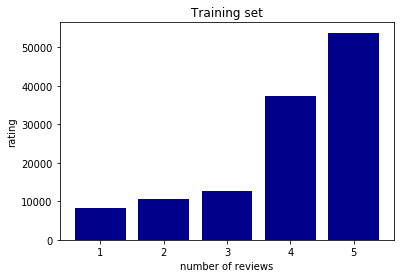

Distribution of the ratings in the validation set:
Number of reviews with a rating of 1: 2828
Number of reviews with a rating of 2: 3576
Number of reviews with a rating of 3: 4389
Number of reviews with a rating of 4: 12539
Number of reviews with a rating of 5: 18467


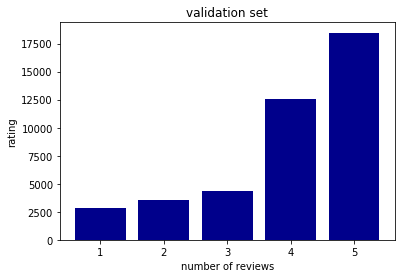

In [42]:

i1=0
i2=0 
i3=0 
i4=0 
i5=0
for i in range(len(y_train)):
    if y_train[i] == 0:
        i1 += 1
    if y_train[i] == 1:
        i2 += 1
    if y_train[i] == 2:
        i3 += 1
    if y_train[i] == 3:
        i4 += 1
    if y_train[i] == 4:
        i5 += 1
print('Distribution of the ratings in the training set:')
print('Number of reviews with a rating of 1: '+str(i1))
print('Number of reviews with a rating of 2: '+str(i2))
print('Number of reviews with a rating of 3: '+str(i3))
print('Number of reviews with a rating of 4: '+str(i4))
print('Number of reviews with a rating of 5: '+str(i5))


import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5] 
  
# heights of bars 
height = [i1, i2, i3, i4, i5] 
  
# labels for bars 
tick_label = ['1', '2', '3', '4', '5'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['darkblue']) 
  
# naming the x-axis 
plt.xlabel('number of reviews') 
# naming the y-axis 
plt.ylabel('rating') 
# plot title 
plt.title('Training set') 
  
# function to show the plot 
plt.show() 


i1=0
i2=0 
i3=0 
i4=0 
i5=0
for i in range(len(y_test)):
    if y_test[i] == 0:
        i1 += 1
    if y_test[i] == 1:
        i2 += 1
    if y_test[i] == 2:
        i3 += 1
    if y_test[i] == 3:
        i4 += 1
    if y_test[i] == 4:
        i5 += 1
print('Distribution of the ratings in the validation set:')
print('Number of reviews with a rating of 1: '+str(i1))
print('Number of reviews with a rating of 2: '+str(i2))
print('Number of reviews with a rating of 3: '+str(i3))
print('Number of reviews with a rating of 4: '+str(i4))
print('Number of reviews with a rating of 5: '+str(i5))


import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5] 
  
# heights of bars 
height = [i1, i2, i3, i4, i5] 
  
# labels for bars 
tick_label = ['1', '2', '3', '4', '5'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['darkblue']) 
  
# naming the x-axis 
plt.xlabel('number of reviews') 
# naming the y-axis 
plt.ylabel('rating') 
# plot title 
plt.title('validation set') 
  
# function to show the plot 
plt.show() 

In [ ]:
y_test[1:10]

**Set class weights for imbalanced classes**

In [174]:
class_weightstrain = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
print(class_weightstrain.shape)
class_weightstrain

(5,)


array([ 3.14275093,  2.22473684,  1.89127517,  0.67470072,  0.45015974])

In [44]:
import keras
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_test.shape

Using TensorFlow backend.


(41799, 5)

In [45]:
y_train[0:10]

array([[ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.]], dtype=float32)

In [47]:
EMBEDDING_DIM =100
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Model with dropout

In [50]:
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.initializers import Constant
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dropout, LSTM, CuDNNLSTM
from keras.regularizers import l1, l2
from keras.constraints import max_norm
model_1_v3_savename = 'TripAdvisor_owntrainedembeddingconvnet_model_0.3.h5'

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(CuDNNLSTM(100, return_sequences = False, stateful = False, kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy','mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 7918, 100)         674600    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 755,905
Trainable params: 81,305
Non-trainable params: 674,600
_________________________________________________________________
None


In [54]:
callbacks = [
             ModelCheckpoint(model_1_v3_savename, monitor='val_acc', verbose=2, 
                             save_best_only=True)]
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=30, validation_data=(X_test_pad, y_test),
                    class_weight=class_weightstrain,verbose=1, callbacks = callbacks)

Train on 126478 samples, validate on 37962 samples
Epoch 1/30
126478/126478 [==============================] - 491s 4ms/step - loss: 1.2607 - acc: 0.4996 - mean_absolute_error: 0.2420 - val_loss: 1.3351 - val_acc: 0.4726 - val_mean_absolute_error: 0.2523

Epoch 00001: val_acc improved from -inf to 0.47263, saving model to TripAdvisor_owntrainedembeddingconvnet_model_0.3.h5
Epoch 2/30
126478/126478 [==============================] - 488s 4ms/step - loss: 1.2957 - acc: 0.4807 - mean_absolute_error: 0.2470 - val_loss: 1.3162 - val_acc: 0.4824 - val_mean_absolute_error: 0.2438

Epoch 00002: val_acc improved from 0.47263 to 0.48240, saving model to TripAdvisor_owntrainedembeddingconvnet_model_0.3.h5
Epoch 3/30
126478/126478 [==============================] - 487s 4ms/step - loss: 1.2630 - acc: 0.4987 - mean_absolute_error: 0.2423 - val_loss: 1.3210 - val_acc: 0.4783 - val_mean_absolute_error: 0.2547

Epoch 00003: val_acc did not improve from 0.48240
Epoch 4/30
126478/126478 [===============

In [53]:
model.save_weights(model_1_v3_savename)
score_val = model.evaluate(X_test_pad, y_test, verbose=0)
print('Validation loss:', score_val[0])
print('Validation accuracy:', score_val[1])

Validation loss: 5.01523367238
Validation accuracy: 0.338593251637


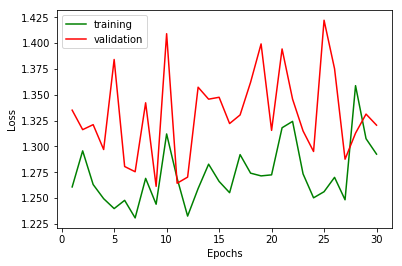

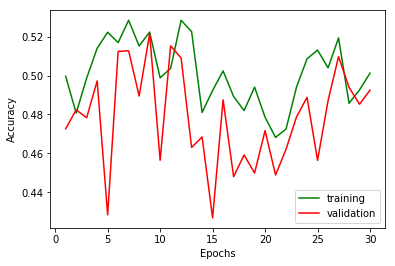

In [63]:


import matplotlib.pyplot as plt

real_epochs = 30
'''
real_epochs = len(history.history['acc'])
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1,real_epochs+1,1),history.history['acc'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_acc'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()
'''
#plt.figure()
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1,real_epochs+1,1),history.history['loss'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_loss'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1,real_epochs+1,1),history.history['acc'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_acc'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [40]:
max_length

3503

## Confusion matrix on validation data

In [55]:
y_prediction = model.predict(X_test_pad)
y_prediction[0]

test_predicted_class = np.argmax(y_prediction,axis=1)
test_predicted_class[0]
len(test_predicted_class)

#y_train = rating_list
#x_val = x_train[:round(0.3*len(Train))]
#y_val = y_train[:round(0.3*len(Train))]

# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(df_val['review_lines'])
sequences = tokenizer_obj.texts_to_sequences(df_val['review_lines'])

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
sentiment =  df_val['Rating'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

X_test_pad  = review_pad
y_test2 = sentiment






Found 6745 unique tokens.
Shape of review tensor: (37962, 7918)
Shape of sentiment tensor: (37962,)


In [41]:
'''
print(round(y_prediction[2000][0]))

print(len(y_prediction))
print(len(y_test2))

ypredictions = list()
for i in range(len(y_prediction)):
    result = round(y_prediction[i][0])
    ypredictions.append(result)

ypredictions
'''

'\nprint(round(y_prediction[2000][0]))\n\nprint(len(y_prediction))\nprint(len(y_test2))\n\nypredictions = list()\nfor i in range(len(y_prediction)):\n    result = round(y_prediction[i][0])\n    ypredictions.append(result)\n\nypredictions\n'

Confusion matrix, without normalization


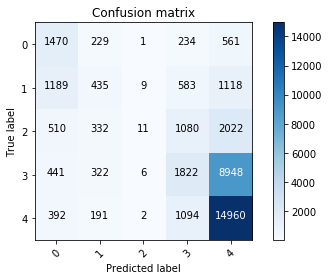

In [56]:

# You can use the code below to plot a confusion matrix


from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
plot_confusion_matrix(y_test2, test_predicted_class) #voor mae: ypredictions

## Misclassifications

In [59]:
df_val.iloc[0]

Review          style in a budget Over recent year , New York ...
Rating                                                          4
Hotel_id                                                      460
review_lines    [style, budget, recent, year, new, york, hotel...
Name: 0, dtype: object

In [60]:
for i in range(100):
    result1 = test_predicted_class[i]
    result2 = df_val.iloc[i][1]
    if (result1 != result2):
        print(" Predicted rating: ", result1, "\n", "True rating: ", result2 , "\n", "Review: ",df_val.iloc[i][0], "\n")

 Predicted rating:  3 
 True rating:  4 
 Review:  style in a budget Over recent year , New York hotel have returned to their former price level , making the task of finding a decent hotel ever harder . The QT hotel provides a great boutique style hotel for those who would like contemporary style hotel accomodation on a budget , without all the frill one would associate with the major hotel , such a the ' W ' . At $ per night for a single room in November , we are not talking cheap , but considering this hotel is situated in the heart of Manhattan in the Times Square area , this wa quite good value . The room I had wa small , but the fixture were all new and clean , plus the bed and bedding were extremely comfortable . It so frustrating to pay say ( $ ) per night at a supposedly luxury hotel and find you have a cheap bed pillow . The owner of the QT have in a lot of area by providing self-service breakfast ( ) where you have plastic plate and cutlery . But when it come to important thi

# Model without dropout

In [48]:
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.initializers import Constant
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dropout, LSTM, CuDNNLSTM
from keras.regularizers import l1, l2
from keras.constraints import max_norm
#model_1_v4_savename = 'TripAdvisor_owntrainedembeddingwithoutdropout_model_0.3.h5'

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(CuDNNLSTM(100, return_sequences = False, stateful = False, kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(Dense(5, activation='softmax'))

Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy','mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 7903, 100)         674600    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 755,905
Trainable params: 81,305
Non-trainable params: 674,600
_________________________________________________________________
None


In [49]:
model.load_weights('TripAdvisor_owntrainedembeddingwithoutdropout_model_0.3.h5')
score_val=model.evaluate(X_test_pad, y_test, verbose=0)
print('Validation MAE:', score_val[1]) #### WRONG NAME, SHOULD BE VALIDATION ACCURACY

Validation MAE: 0.433766358048


callbacks = [
             ModelCheckpoint(model_1_v4_savename, monitor='val_acc', verbose=2, 
                             save_best_only=True)]
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=30, validation_data=(X_test_pad, y_test),
                    class_weight=class_weightstrain,verbose=1, callbacks = callbacks)

In [51]:


import matplotlib.pyplot as plt

real_epochs = 30
'''
real_epochs = len(history.history['acc'])
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1,real_epochs+1,1),history.history['acc'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_acc'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()
'''
#plt.figure()
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1,real_epochs+1,1),history.history['loss'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_loss'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1,real_epochs+1,1),history.history['acc'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_acc'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>

In [40]:
max_length

3503

## Confusion matrix on validation data

In [52]:
y_prediction = model.predict(X_test_pad)
y_prediction[0]

test_predicted_class = np.argmax(y_prediction,axis=1)
test_predicted_class[0]
len(test_predicted_class)

#y_train = rating_list
#x_val = x_train[:round(0.3*len(Train))]
#y_val = y_train[:round(0.3*len(Train))]

# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(df_val['review_lines'])
sequences = tokenizer_obj.texts_to_sequences(df_val['review_lines'])

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
sentiment =  df_val['Rating'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

X_test_pad  = review_pad
y_test2 = sentiment






Found 6745 unique tokens.
Shape of review tensor: (41799, 7903)
Shape of sentiment tensor: (41799,)


In [ ]:
'''
print(round(y_prediction[2000][0]))

print(len(y_prediction))
print(len(y_test2))

ypredictions = list()
for i in range(len(y_prediction)):
    result = round(y_prediction[i][0])
    ypredictions.append(result)

ypredictions
'''

Confusion matrix, without normalization


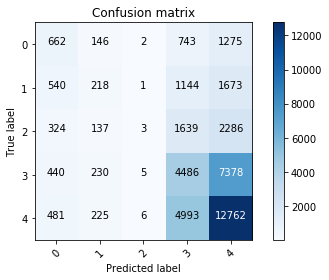

In [53]:

# You can use the code below to plot a confusion matrix


from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
plot_confusion_matrix(y_test2, test_predicted_class) #voor mae: ypredictions

## Misclassifications

In [54]:
df_val.iloc[0]

Review               Wonderful beach destination beachfront cabin
Rating                                                          3
Hotel_id                                                      835
review_lines    [wonderful, beach, destination, beachfront, ca...
Name: 0, dtype: object

In [55]:
for i in range(100):
    result1 = test_predicted_class[i]
    result2 = df_val.iloc[i][1]
    if (result1 != result2):
        print(" Predicted rating: ", result1, "\n", "True rating: ", result2 , "\n", "Review: ",df_val.iloc[i][0], "\n")

 Predicted rating:  4 
 True rating:  3 
 Review:  Wonderful beach destination beachfront cabin 

 Predicted rating:  3 
 True rating:  0 
 Review:  Awful We booked to stay at the Westin under the prefered guest status . It took 45 minute to check in and a my husband had booked the hotel on my behalf but in my name I wa asked if my husband knew that I wa there and did I have his . Took a further hour for the bag to come to the room . to the manager wa . the manager and the reception staff take lesson from the bell boy and customer service a they were the only good thing about the hotel . I have now taken up the matter with the starwood group head office . 

 Predicted rating:  4 
 True rating:  3 
 Review:  Location ! Well , SF is pricey . However , I believe the Chancellor is a decent option within the under $ 200 range . Yes , the room are rather small , and the decor not a fresh a one would like . but it clean , and the location is probably one of the best in the Union Square area .